In [1]:
import sys
import warnings
#from torchtext import data

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.preprocessing import normalize
sns.set_context(context="talk")
%matplotlib inline


from keras import backend as K

def focal_loss(gamma=2., weights=1):   #weights np.asarray()
    weights= K.variable(weights)
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(),1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return - K.sum(weights* K.pow(1. - y_pred, gamma)* y_true * K.log(y_pred), axis=-1) 
    return focal_loss_fixed

import keras
import os, re, sys
import pandas as pd
from keras.utils import to_categorical
import ast
from sklearn.utils import class_weight
from keras.preprocessing import sequence
from keras.models import load_model
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk import WordNetLemmatizer
import itertools
from collections import Counter
from os import listdir
from os.path import isfile, join
import  json
from sklearn.utils import class_weight


from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, Input
from keras.preprocessing import sequence
from keras.models import Model
from keras.layers import LSTM,GRU,Dense
from keras.utils import Sequence,to_categorical

stoplist = stopwords.words('english')
lemmatizer=WordNetLemmatizer()

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def cleaner(post):       
    s= re.sub(r"http\S+", " <url> ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " <hashtag> ", s) ########3
    s= re.sub(r'@\w+ ?', " <user> ", s)##############    
    s= s.lower()
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " <number> ",  s)
    s=re.sub(r'\b[0-9][0-9]\b', " <number> ",  s)
    s=re.sub(r'\b[0-9][0-9][0-9]\b', " <number> ",  s)
    s=re.sub(r'\b[0-9][0-9][0-9][0-9]\b', " <number> ",  s)
    s=emoji_pattern.sub(r'', s)
    s= list(s.split())
    s=[lemmatizer.lemmatize(token) for token in s]
        
    return s

def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Using TensorFlow backend.


In [2]:
df_train=pd.read_csv("../Train_data_compeition.csv")
df_val=pd.read_csv("../Validation_data_competition.csv")
df_test=pd.read_csv("../testset-competition.csv")

from collections import Counter
print ("conteo de tweets clase Harassment",Counter(df_train['harassment']))
print ("conteo de tweets clase IndirectH",Counter(df_train['IndirectH']))
print ("conteo de tweets clase PhysicalH",Counter(df_train['PhysicalH']))
print ("conteo de tweets clase SexualH",Counter(df_train['SexualH']))

conteo de tweets clase Harassment Counter({0: 3661, 1: 2713})
conteo de tweets clase IndirectH Counter({0: 6319, 1: 55})
conteo de tweets clase PhysicalH Counter({0: 6298, 1: 76})
conteo de tweets clase SexualH Counter({0: 3792, 1: 2582})


In [3]:
def invertir_valores(lista):
    new_lista=[]
    for reg in lista:
        temp=reg
        if reg[0]==0:
            temp[0]=1
        else:  #si el primero es 1, entonces se pone en 0 esa pos
            temp[0]=0
        new_lista.append(temp)
    return np.asarray(new_lista)           
            

In [4]:
etiquetas=df_train.values[:,2:]
etiquetas=invertir_valores(etiquetas)
etiquetas[:30]

array([[0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1]], dtype=object)

In [5]:
y_train=etiquetas

In [6]:
y_train_num=[]
for reg in y_train:
    y_train_num.append(np.argmax(reg))
y_train_num=np.asarray(y_train_num)
y_train_num[:30]

array([3, 0, 0, 3, 3, 0, 3, 3, 0, 0, 0, 3, 0, 3, 3, 0, 0, 3, 0, 0, 3, 3, 0,
       3, 3, 0, 3, 0, 0, 3])

In [7]:
etiquetas_val=df_val.values[:,2:]
etiquetas_val=invertir_valores(etiquetas_val)
etiquetas_val[:30]
y_val=etiquetas_val
y_val_num=[]
for reg in y_val:
    y_val_num.append(np.argmax(reg))
y_val_num=np.asarray(y_val_num)
y_val_num[:30]

array([0, 0, 3, 0, 3, 0, 0, 3, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 3,
       3, 0, 3, 0, 3, 0, 3])

In [9]:
data_train=[]
for tw in df_train['tweet_content']:
    data_train.append(cleaner(tw))

    
embeddings_index = {}
#f = open(os.path.join("../../glove.twitter.27B/glove.twitter.27B.100d.txt"))#'glove.twitter.27B.100d.txt'))
f = open(os.path.join("/home/mbugueno/Documentos/glove.twitter.27B/glove.twitter.27B.100d.txt")) 
for line in f: 
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))
                                                                        
word_index=dict()
j=1
for frase in data_train:
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1
    
embedding_vector=100
embedding_matrix = np.zeros((len(word_index.keys())+1, embedding_vector))   #puede probar otra inicialización

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Se encontraron 1193514 terminos con sus vectores de embedding.


[  0.43526359  28.97272727  20.96710526   0.61715724]


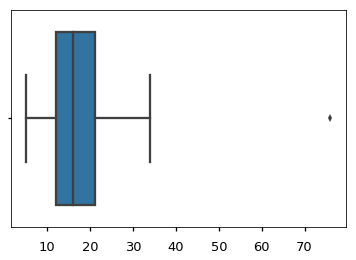

In [10]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_num), y_train_num)#{0: 3.,   1: 6.,   2: 5.,  3: 3.}
print (class_weights)
x_new_train = [[word_index[word] for word in text] for text in data_train]

sns.boxplot(list(map(len,x_new_train)))

In [11]:
max_input_lenght = max(list(map(len,x_new_train))) #modificar este valor en base a su experimentación
X_train = sequence.pad_sequences(x_new_train,maxlen=max_input_lenght,padding='post',value=0)
print (max_input_lenght) 
X_train.shape

data_val=[]
for tw in df_val['tweet_content']:
    data_val.append(cleaner(tw))
print (Counter(y_val_num))
    
    
Vec_train=[]
tweets_c_a=data_train
vocab_train=[]
vocab=list(embeddings_index.keys())
for post in tweets_c_a:
    posteo=[]
    for term in post:   #para todos los terminos de un tweet 
        vector=embeddings_index.get(term)
        if vector is None:       
            posteo.append(np.zeros(100))
        else:
            posteo.append(np.asarray(vector))
            vocab_train.append(term)
    Vec_train.append(np.asarray(posteo))
    
Vec_val_ig=[]
tweets_l_vali=data_val
vocab=list(embeddings_index.keys())
for post in tweets_l_vali:
    temp=[]
    for term in post:  
        if term in vocab_train:
            vector=embeddings_index.get(term)
            if vector is None:       
                temp.append(np.zeros(100))
            else:
                temp.append(np.asarray(vector))
    Vec_val_ig.append(temp)

all_val=[]
for text in data_val:
    temp=[]
    for word in text:
        try:
            temp.append(word_index[word])
        except:
            continue
    all_val.append(temp)
    
x_new_val=all_val
X_val_ig = sequence.pad_sequences(x_new_val,maxlen=max_input_lenght,padding='post',value=0)
print (np.asarray(X_val_ig).shape)

76
Counter({0: 1493, 3: 525, 1: 71, 2: 36})
(2125, 76)


In [12]:
embedding_vector=100
embedding_layer = Embedding(input_dim=len(word_index.keys())+1,output_dim=embedding_vector,weights=[embedding_matrix],
                     input_length=max_input_lenght,trainable=False)

sequence_input = Input(shape=(max_input_lenght,))
embedded_sequences = embedding_layer(sequence_input)
batch = BatchNormalization()(embedded_sequences)
cov1= Conv1D(128, 5, activation='relu',padding='same')(batch)
pool = MaxPooling1D(pool_size=3)(cov1)    
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
cov1= Conv1D(64, 5, activation='relu',padding='same')(drop)
pool = MaxPooling1D(pool_size=3)(cov1)
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
flat = Flatten()(drop)
preds = Dense(64, activation='relu')(flat)
preds = BatchNormalization()(preds)
preds = Dense(4, activation='sigmoid')(preds)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [13]:
history = model.fit(X_train, y_train,batch_size=64,epochs=10,verbose=1,validation_data=(X_val_ig,y_val),class_weight=class_weights)
model.save('baselines_4/cnn1_ce10_100.h5')

Train on 6374 samples, validate on 2125 samples
Epoch 1/10
6374/6374 [==============================] - 6s 899us/step - loss: 1.1784 - acc: 0.5107 - val_loss: 0.7035 - val_acc: 0.8480
Epoch 2/10
6374/6374 [==============================] - 4s 594us/step - loss: 0.7757 - acc: 0.7767 - val_loss: 0.5302 - val_acc: 0.8438
Epoch 3/10
6374/6374 [==============================] - 4s 570us/step - loss: 0.5698 - acc: 0.8149 - val_loss: 0.4752 - val_acc: 0.8659
Epoch 4/10
6374/6374 [==============================] - 4s 573us/step - loss: 0.4649 - acc: 0.8494 - val_loss: 0.4292 - val_acc: 0.8781
Epoch 5/10
6374/6374 [==============================] - 4s 574us/step - loss: 0.4265 - acc: 0.8615 - val_loss: 0.4215 - val_acc: 0.8861
Epoch 6/10
6374/6374 [==============================] - 4s 572us/step - loss: 0.3950 - acc: 0.8748 - val_loss: 0.4256 - val_acc: 0.8842
Epoch 7/10
6374/6374 [==============================] - 4s 621us/step - loss: 0.3905 - acc: 0.8731 - val_loss: 0.4320 - val_acc: 0.8838


[[ 0.9087472   0.00847887  0.00542828  0.0086867 ]
 [ 0.77237213  0.0058494   0.00795346  0.0162916 ]
 [ 0.03376836  0.00226629  0.02512477  0.99998164]
 [ 0.91600072  0.00459374  0.00281729  0.00483924]
 [ 0.43365172  0.05378655  0.08992301  0.24665391]]
[0 0 3 0 0]
Accuracy sobre validacion: 0.885176470588
F1-score None sobre validación: [ 0.929514    0.          0.          0.84362934]
F1-score macro sobre validación: 0.443285836068
Precision None sobre validación: [ 0.89467162  0.          0.          0.85518591]
Recall None sobre validación: [ 0.96718017  0.          0.          0.83238095]


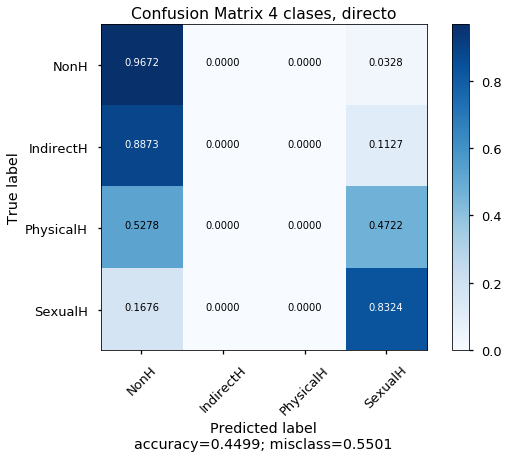

In [14]:
predict = model.predict(X_val_ig, batch_size=64)
print (predict[:5])
predict= predict.argmax(axis=-1)
print (predict[:5])
acc_val= accuracy_score(y_val_num, predict)
f1_val=f1_score(y_val_num, predict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_num, predict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_num, predict, average=None) 
pre=precision_score(y_val_num, predict, average=None) 
matriz_val=confusion_matrix(y_val_num, predict)
print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH",'IndirectH','PhysicalH','SexualH'],"Confusion Matrix 4 clases, directo")

In [15]:
class_weights

array([  0.43526359,  28.97272727,  20.96710526,   0.61715724])

In [16]:
embedding_vector=100
embedding_layer = Embedding(input_dim=len(word_index.keys())+1,output_dim=embedding_vector,weights=[embedding_matrix],
                     input_length=max_input_lenght,trainable=False)

sequence_input = Input(shape=(max_input_lenght,))
embedded_sequences = embedding_layer(sequence_input)
batch = BatchNormalization()(embedded_sequences)
cov1= Conv1D(128, 5, activation='relu',padding='same')(batch)
pool = MaxPooling1D(pool_size=3)(cov1)    
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
cov1= Conv1D(64, 5, activation='relu',padding='same')(drop)
pool = MaxPooling1D(pool_size=3)(cov1)
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
flat = Flatten()(drop)
preds = Dense(64, activation='relu')(flat)
preds = BatchNormalization()(preds)
preds = Dense(4, activation='softmax')(preds)
model = Model(sequence_input, preds)
model.compile(loss=focal_loss(2, class_weights),optimizer='adam',metrics=['acc'])

history = model.fit(X_train, y_train,batch_size=64,epochs=10,verbose=1,validation_data=(X_val_ig,y_val),class_weight=class_weights)
model.save('baselines_4/cnn1_focal10_100.h5')

Train on 6374 samples, validate on 2125 samples
Epoch 1/10
6374/6374 [==============================] - 5s 834us/step - loss: 1.3028 - acc: 0.2667 - val_loss: 1.7134 - val_acc: 0.4951
Epoch 2/10
6374/6374 [==============================] - 4s 557us/step - loss: 1.0899 - acc: 0.3117 - val_loss: 1.9899 - val_acc: 0.0861
Epoch 3/10
6374/6374 [==============================] - 4s 585us/step - loss: 0.9427 - acc: 0.3726 - val_loss: 1.1904 - val_acc: 0.3652
Epoch 4/10
6374/6374 [==============================] - 4s 583us/step - loss: 0.8109 - acc: 0.4045 - val_loss: 1.0097 - val_acc: 0.3209
Epoch 5/10
6374/6374 [==============================] - 4s 601us/step - loss: 0.8258 - acc: 0.4562 - val_loss: 1.0232 - val_acc: 0.5129
Epoch 6/10
6374/6374 [==============================] - 4s 578us/step - loss: 0.6532 - acc: 0.4831 - val_loss: 0.9997 - val_acc: 0.5694
Epoch 7/10
6374/6374 [==============================] - 4s 575us/step - loss: 0.6362 - acc: 0.4970 - val_loss: 0.9282 - val_acc: 0.4847


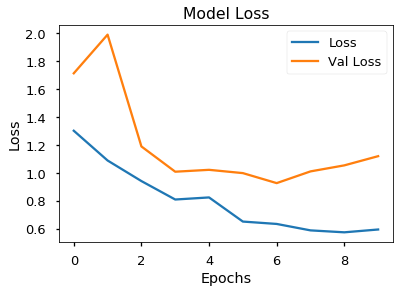

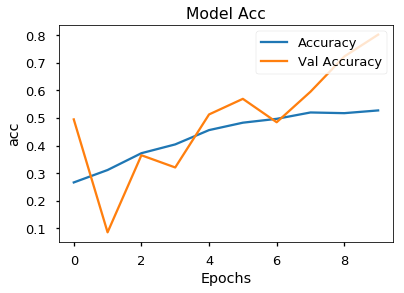

In [17]:
plt.plot(history.history['loss'],label="Loss")
plt.plot(history.history['val_loss'],label="Val Loss")
plt.title("Model Loss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(history.history['acc'],label="Accuracy" )
plt.plot(history.history['val_acc'],label="Val Accuracy" )
plt.title("Model Acc") 
plt.ylabel('acc')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

[0 0 3 0 0]
Accuracy sobre validacion: 0.801882352941
F1-score None sobre validación: [ 0.89635317  0.1588785   0.02941176  0.67695962]
F1-score macro sobre validación: 0.440400764079
Precision None sobre validación: [ 0.85793019  0.11888112  0.03125     0.89905363]
Recall None sobre validación: [ 0.9383791   0.23943662  0.02777778  0.54285714]


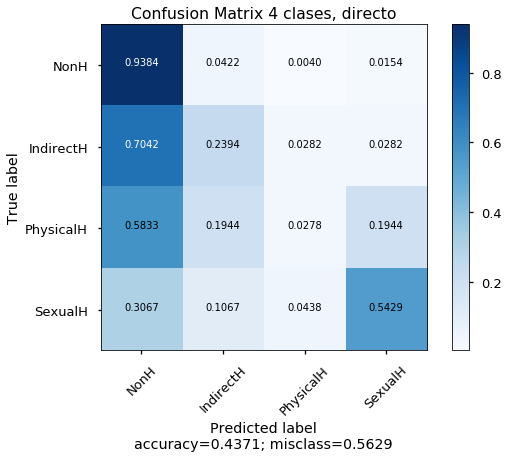

In [18]:
predict = model.predict(X_val_ig, batch_size=64)
predict= predict.argmax(axis=-1)
print (predict[:5])
acc_val= accuracy_score(y_val_num, predict)
f1_val=f1_score(y_val_num, predict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_num, predict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_num, predict, average=None) 
pre=precision_score(y_val_num, predict, average=None) 
matriz_val=confusion_matrix(y_val_num, predict)
print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH",'IndirectH','PhysicalH','SexualH'],"Confusion Matrix 4 clases, directo")

In [19]:
embedding_vector=100
embedding_layer = Embedding(input_dim=len(word_index.keys())+1,output_dim=embedding_vector,weights=[embedding_matrix],
                     input_length=max_input_lenght,trainable=False)

sequence_input = Input(shape=(max_input_lenght,))
embedded_sequences = embedding_layer(sequence_input)
batch = BatchNormalization()(embedded_sequences)
cov1= Conv1D(128, 5, activation='relu',padding='same')(batch)
pool = MaxPooling1D(pool_size=3)(cov1)    
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
cov1= Conv1D(64, 5, activation='relu',padding='same')(drop)
pool = MaxPooling1D(pool_size=3)(cov1)
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
flat = Flatten()(drop)
preds = Dense(100, activation='relu')(flat)
preds = BatchNormalization()(preds)
preds = Dense(4, activation='softmax')(preds)
model = Model(sequence_input, preds)
model.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 76)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 76, 100)           1618900   
_________________________________________________________________
batch_normalization_9 (Batch (None, 76, 100)           400       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 76, 128)           64128     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 25, 128)           0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 25, 128)           512       
_________________________________________________________________
dropout_5 (Dropout)          (None, 25, 128)           0         
__________

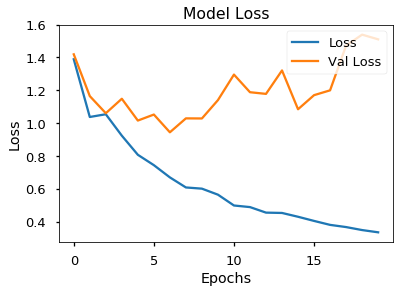

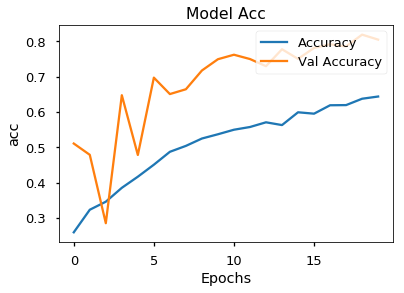

[0 0 3 0 0]
Accuracy sobre validacion: 0.805176470588
F1-score None sobre validación: [ 0.90495737  0.16783217  0.11510791  0.64419476]
F1-score macro sobre validación: 0.458023052741
Precision None sobre validación: [ 0.85603345  0.16666667  0.0776699   0.93478261]
Recall None sobre validación: [ 0.95981246  0.16901408  0.22222222  0.49142857]


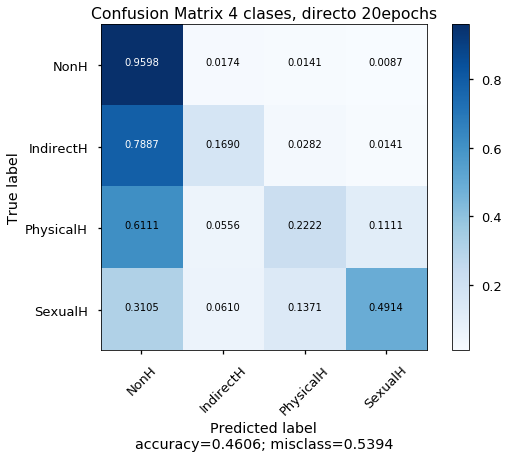

In [20]:
history = model.fit(X_train, y_train,batch_size=64,epochs=20,verbose=0,validation_data=(X_val_ig,y_val),class_weight=class_weights)
model.save('baselines_4/cnn1_100_focal20_100.h5')

plt.plot(history.history['loss'],label="Loss")
plt.plot(history.history['val_loss'],label="Val Loss")
plt.title("Model Loss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(history.history['acc'],label="Accuracy" )
plt.plot(history.history['val_acc'],label="Val Accuracy" )
plt.title("Model Acc") 
plt.ylabel('acc')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predict = model.predict(X_val_ig, batch_size=64)
predict= predict.argmax(axis=-1)
print (predict[:5])
acc_val= accuracy_score(y_val_num, predict)
f1_val=f1_score(y_val_num, predict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_num, predict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_num, predict, average=None) 
pre=precision_score(y_val_num, predict, average=None) 
matriz_val=confusion_matrix(y_val_num, predict)
print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH",'IndirectH','PhysicalH','SexualH'],"Confusion Matrix 4 clases, directo 20epochs")

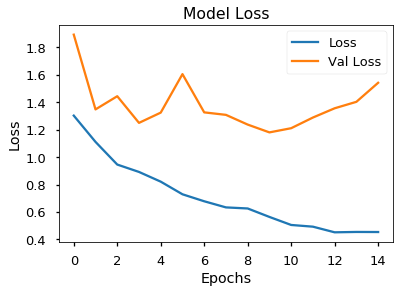

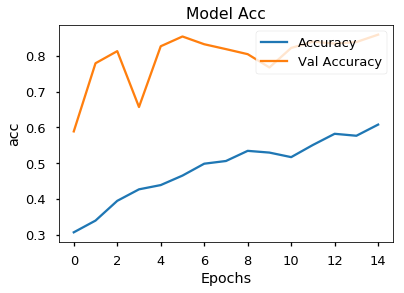

[0 0 3 0 0]
Accuracy sobre validacion: 0.859294117647
F1-score None sobre validación: [ 0.9201278   0.0625      0.05128205  0.77563452]
F1-score macro sobre validación: 0.452386091144
Precision None sobre validación: [ 0.87965791  0.12        0.33333333  0.83043478]
Recall None sobre validación: [ 0.964501    0.04225352  0.02777778  0.72761905]


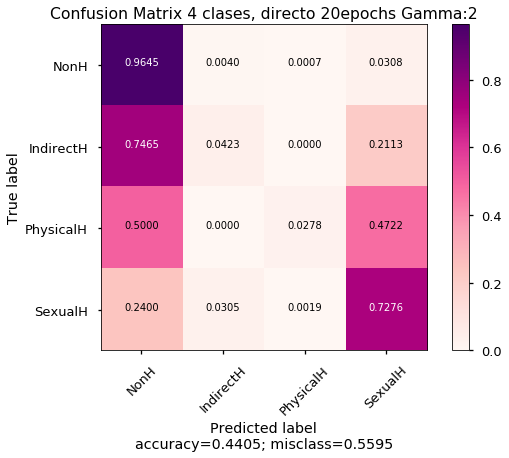

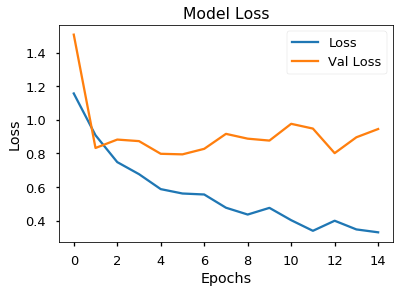

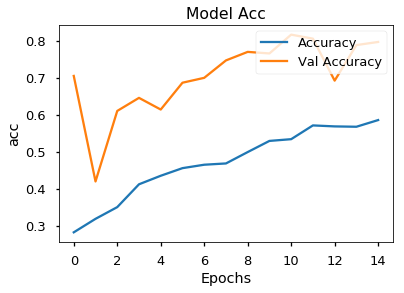

[0 0 3 0 0]
Accuracy sobre validacion: 0.797176470588
F1-score None sobre validación: [ 0.8859146   0.18723404  0.08510638  0.6746988 ]
F1-score macro sobre validación: 0.458238453999
Precision None sobre validación: [ 0.8449848   0.13414634  0.18181818  0.91803279]
Recall None sobre validación: [ 0.93101139  0.30985915  0.05555556  0.53333333]


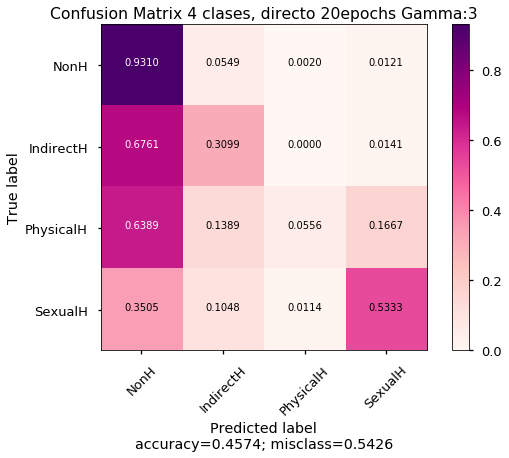

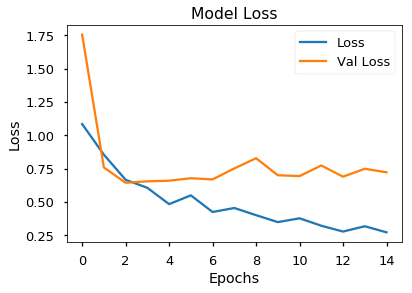

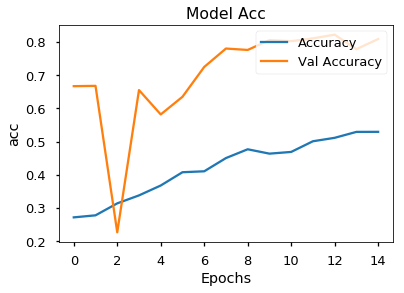

[0 0 3 0 0]
Accuracy sobre validacion: 0.808941176471
F1-score None sobre validación: [ 0.89831566  0.13836478  0.06349206  0.64720195]
F1-score macro sobre validación: 0.436843611995
Precision None sobre validación: [ 0.84063047  0.125       0.07407407  0.8956229 ]
Recall None sobre validación: [ 0.964501    0.15492958  0.05555556  0.50666667]


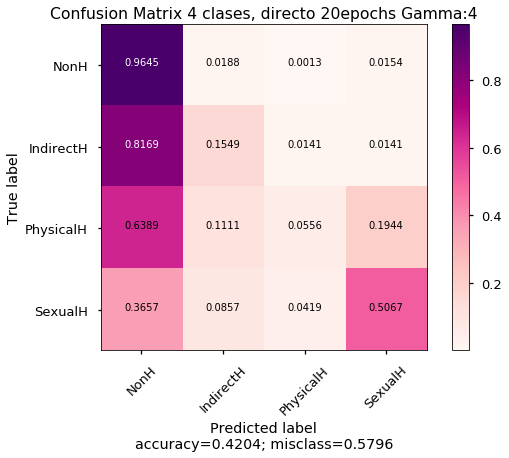

In [21]:
gammas=[2,3,4]
for gamma in gammas:
    embedding_vector=100
    embedding_layer = Embedding(input_dim=len(word_index.keys())+1,output_dim=embedding_vector,weights=[embedding_matrix],
                         input_length=max_input_lenght,trainable=False)
    sequence_input = Input(shape=(max_input_lenght,))
    embedded_sequences = embedding_layer(sequence_input)
    batch = BatchNormalization()(embedded_sequences)
    cov1= Conv1D(128, 5, activation='relu',padding='same')(batch)
    pool = MaxPooling1D(pool_size=3)(cov1)    
    batch = BatchNormalization()(pool)
    drop = Dropout(0.65)(batch)
    cov1= Conv1D(64, 5, activation='relu',padding='same')(drop)
    pool = MaxPooling1D(pool_size=3)(cov1)
    batch = BatchNormalization()(pool)
    drop = Dropout(0.65)(batch)
    flat = Flatten()(drop)
    preds = Dense(100, activation='relu')(flat)
    preds = BatchNormalization()(preds)
    preds = Dense(4, activation='softmax')(preds)
    model = Model(sequence_input, preds)
    model.compile(loss=focal_loss(gamma,weights=class_weights),optimizer='adam',metrics=['acc'])
    history = model.fit(X_train, y_train,batch_size=64,epochs=15,verbose=0,validation_data=(X_val_ig,y_val),class_weight=class_weights)
    model.save('baselines_4/cnn1_100_focal20_100_g'+str(gamma)+'.h5')
    plt.plot(history.history['loss'],label="Loss")
    plt.plot(history.history['val_loss'],label="Val Loss")
    plt.title("Model Loss") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.plot(history.history['acc'],label="Accuracy" )
    plt.plot(history.history['val_acc'],label="Val Accuracy" )
    plt.title("Model Acc") 
    plt.ylabel('acc')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    predict = model.predict(X_val_ig, batch_size=64)
    predict= predict.argmax(axis=-1)
    print (predict[:5])
    acc_val= accuracy_score(y_val_num, predict)
    f1_val=f1_score(y_val_num, predict, average=None)  # labels=np.unique(trainPredict)
    f1_val_ma=f1_score(y_val_num, predict, average='macro')  # labels=np.unique(trainPredict)
    rec=recall_score(y_val_num, predict, average=None) 
    pre=precision_score(y_val_num, predict, average=None) 
    matriz_val=confusion_matrix(y_val_num, predict)
    print ("Accuracy sobre validacion:",acc_val)  
    print ("F1-score None sobre validación:",f1_val)
    print ("F1-score macro sobre validación:",f1_val_ma)
    print ("Precision None sobre validación:",pre)
    print ("Recall None sobre validación:",rec)

    plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH",'IndirectH','PhysicalH','SexualH'],"Confusion Matrix 4 clases, directo 20epochs Gamma:"+str(gamma), cmap='RdPu')

In [22]:
maximo_s=max(map(len,Vec_train)) #91 // probar con 60 (bigote mayor)
print (maximo_s)

X_train_rnn = sequence.pad_sequences(Vec_train,maxlen=maximo_s,padding='pre',truncating='post',value=np.zeros(100),dtype='float32') 
X_val_rnn_ig = sequence.pad_sequences(Vec_val_ig,maxlen=maximo_s,padding='pre',truncating='post',value=np.zeros(100),dtype='float32') 

76


In [23]:
def create_simple_GRU(unidades,opt,input_s):
    model = Sequential()
    model.add(GRU(units=unidades,return_sequences=False,input_shape=input_s))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(4, activation='softmax')) 
    model.compile(loss=focal_loss(2,weights=class_weights), optimizer=opt, metrics=['accuracy'])
    return model

def create_complex_GRU(unidades,unidades2,opt,input_s):
    model = Sequential()
    model.add(GRU(units=unidades,return_sequences=True,input_shape=input_s))
    model.add(Dropout(0.3))
    model.add(GRU(units=unidades2,return_sequences=False,input_shape=input_s))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax')) 
    model.compile(loss=focal_loss(2,weights=class_weights), optimizer=opt, metrics=['accuracy'])
    return model

def create_complex_GRU_2(unidades,unidades2,opt,input_s):
    #sgd=optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9)
    model = Sequential()
    model.add(GRU(units=unidades,return_sequences=True,input_shape=input_s))
    model.add(Dropout(0.45))
    model.add(BatchNormalization())
    model.add(GRU(units=unidades2,return_sequences=False,input_shape=input_s ))#, recurrent_regularizer=regularizers.l1(0.01), kernel_regularizer=regularizers.l2(0.01) ))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(4, activation='softmax')) # kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01))
    model.compile(loss=focal_loss(2,weights=class_weights), optimizer=opt, metrics=['accuracy'])
    return model

def create_complex_GRU_3(unidades,unidades2,unidades3,opt,input_s):
    #256,128,64
    model3 = Sequential()
    model3.add(GRU(units=unidades,return_sequences=True,input_shape=input_s))
    model3.add(Dropout(0.65))
    model3.add(BatchNormalization())
    model3.add(GRU(units=unidades2,return_sequences=True,input_shape=input_s ))#, recurrent_regularizer=regularizers.l1(0.01), kernel_regularizer=regularizers.l2(0.01) ))
    model3.add(Dropout(0.45))
    model3.add(BatchNormalization())
    model3.add(GRU(units=unidades3,return_sequences=False,input_shape=input_s ))#,
    model3.add(Dropout(0.35))
    model3.add(BatchNormalization())
    model3.add(Dense(4, activation='softmax')) # kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01))
    model3.compile(loss=focal_loss(2,weights=class_weights), optimizer=opt, metrics=['accuracy'])
    return model3

In [24]:
models1 = create_simple_GRU(64,"adam",X_train_rnn[0].shape) #modificar post experimentación
historys1 = models1.fit(X_train_rnn, y_train,epochs=15,batch_size=64,verbose=0, validation_data=(X_val_rnn_ig, y_val))   
models1.save('baselines_4/rnn_simple_100_focal15.h5')

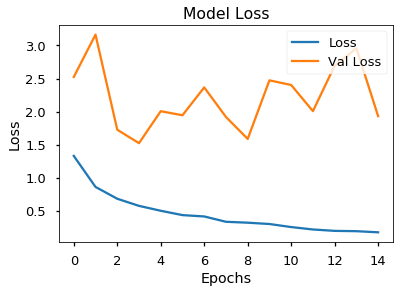

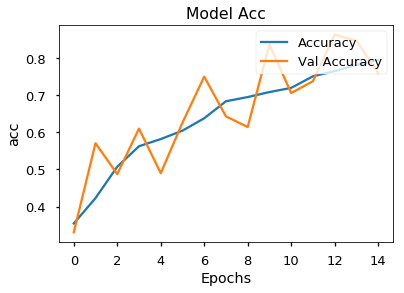

[0 0 3 3 1]
Accuracy sobre validacion: 0.760470588235
F1-score None sobre validación: [ 0.87486554  0.10218978  0.11016949  0.77602524]
F1-score macro sobre validación: 0.465812513086
Precision None sobre validación: [ 0.94135802  0.06896552  0.065       0.86619718]
Recall None sobre validación: [ 0.81714668  0.1971831   0.36111111  0.70285714]


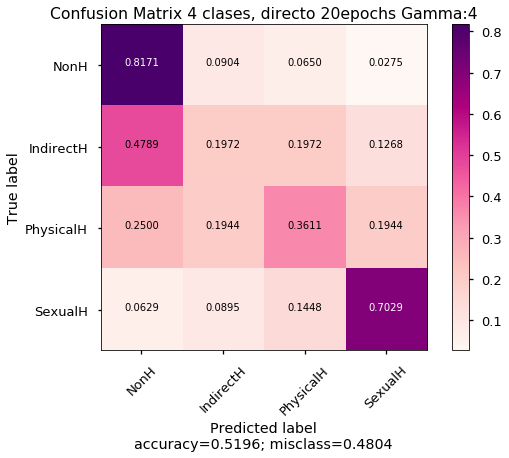

In [25]:
plt.plot(historys1.history['loss'],label="Loss")
plt.plot(historys1.history['val_loss'],label="Val Loss")
plt.title("Model Loss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(historys1.history['acc'],label="Accuracy" )
plt.plot(historys1.history['val_acc'],label="Val Accuracy" )
plt.title("Model Acc") 
plt.ylabel('acc')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predict = models1.predict(X_val_rnn_ig, batch_size=64).argmax(axis=-1)
print (predict[:5])
acc_val= accuracy_score(y_val_num, predict)
f1_val=f1_score(y_val_num, predict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_num, predict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_num, predict, average=None) 
pre=precision_score(y_val_num, predict, average=None) 
matriz_val=confusion_matrix(y_val_num, predict)
print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH",'IndirectH','PhysicalH','SexualH'],"Confusion Matrix 4 clases, directo 20epochs Gamma:"+str(gamma), cmap='RdPu')

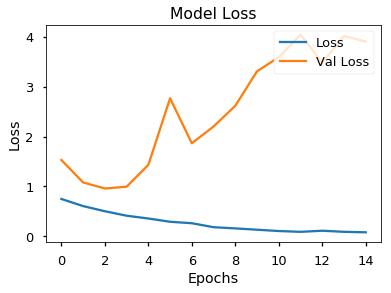

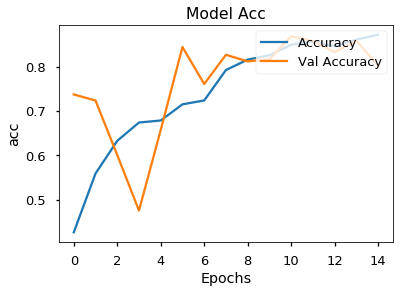

[0 3 3 3 3]
Accuracy sobre validacion: 0.802352941176
F1-score None sobre validación: [ 0.88498746  0.09722222  0.13903743  0.79787234]
F1-score macro sobre validación: 0.479779863874
Precision None sobre validación: [ 0.95146379  0.09589041  0.08609272  0.74626866]
Recall None sobre validación: [ 0.82719357  0.09859155  0.36111111  0.85714286]


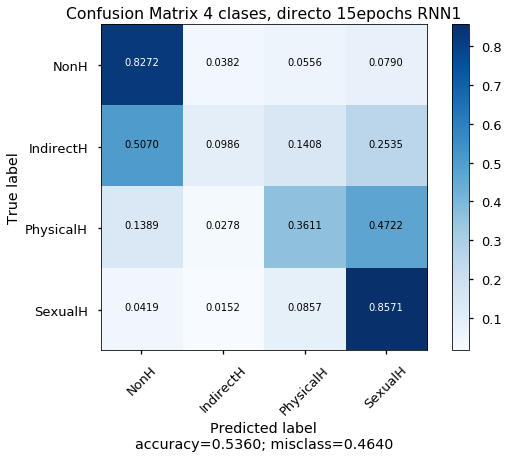

In [26]:
model1 = create_complex_GRU(128,64,"adam",X_train_rnn[0].shape) #modificar post experimentación
history1 = model1.fit(X_train_rnn, y_train,epochs=15,batch_size=64,verbose=0, validation_data=(X_val_rnn_ig, y_val))   
model1.save('baselines_4/rnn1_100_focal15.h5')

plt.plot(history1.history['loss'],label="Loss")
plt.plot(history1.history['val_loss'],label="Val Loss")
plt.title("Model Loss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(history1.history['acc'],label="Accuracy" )
plt.plot(history1.history['val_acc'],label="Val Accuracy" )
plt.title("Model Acc") 
plt.ylabel('acc')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predict = model1.predict(X_val_rnn_ig, batch_size=64).argmax(axis=-1)
print (predict[:5])
acc_val= accuracy_score(y_val_num, predict)
f1_val=f1_score(y_val_num, predict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_num, predict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_num, predict, average=None) 
pre=precision_score(y_val_num, predict, average=None) 
matriz_val=confusion_matrix(y_val_num, predict)
print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH",'IndirectH','PhysicalH','SexualH'],"Confusion Matrix 4 clases, directo 15epochs RNN1")

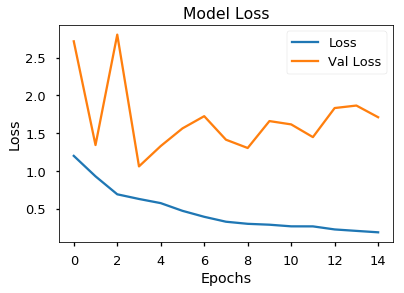

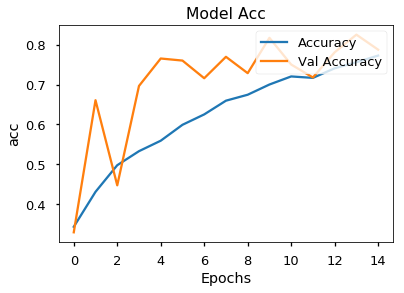

Accuracy sobre validacion: 0.787294117647
F1-score None sobre validación: [ 0.8779625   0.14334471  0.08130081  0.80635551]
F1-score macro sobre validación: 0.477240884687
Precision None sobre validación: [ 0.93028486  0.09459459  0.05747126  0.84232365]
Recall None sobre validación: [ 0.83121232  0.29577465  0.13888889  0.77333333]


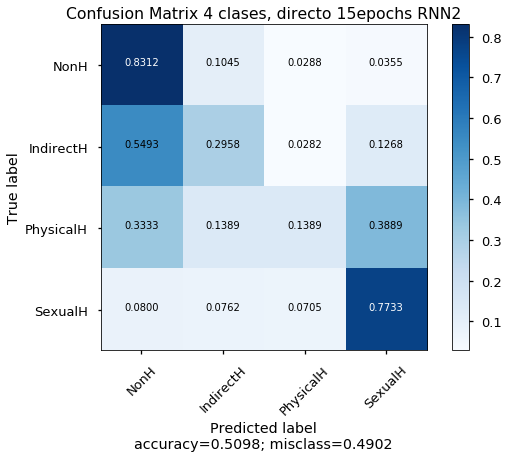

In [27]:
model2 = create_complex_GRU_2(128,64,"adam",X_train_rnn[0].shape) #modificar post experimentación
history2 = model2.fit(X_train_rnn, y_train,epochs=15,batch_size=64,verbose=0, validation_data=(X_val_rnn_ig, y_val))   
model2.save('baselines_4/rnn2_100_focal15.h5')

plt.plot(history2.history['loss'],label="Loss")
plt.plot(history2.history['val_loss'],label="Val Loss")
plt.title("Model Loss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(history2.history['acc'],label="Accuracy" )
plt.plot(history2.history['val_acc'],label="Val Accuracy" )
plt.title("Model Acc") 
plt.ylabel('acc')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predict = model2.predict(X_val_rnn_ig, batch_size=64).argmax(axis=-1)
acc_val= accuracy_score(y_val_num, predict)
f1_val=f1_score(y_val_num, predict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_num, predict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_num, predict, average=None) 
pre=precision_score(y_val_num, predict, average=None) 
matriz_val=confusion_matrix(y_val_num, predict)
print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH",'IndirectH','PhysicalH','SexualH'],"Confusion Matrix 4 clases, directo 15epochs RNN2")

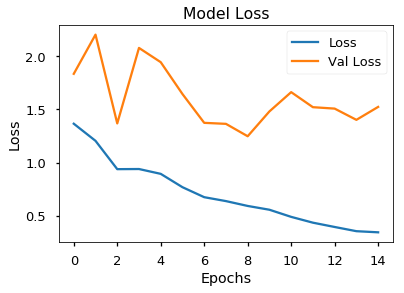

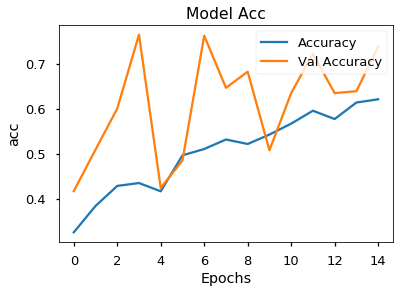

Accuracy sobre validacion: 0.738352941176
F1-score None sobre validación: [ 0.84843982  0.12787724  0.09815951  0.78486056]
F1-score macro sobre validación: 0.464834281629
Precision None sobre validación: [ 0.95246038  0.078125    0.06299213  0.82254697]
Recall None sobre validación: [ 0.76490288  0.35211268  0.22222222  0.75047619]


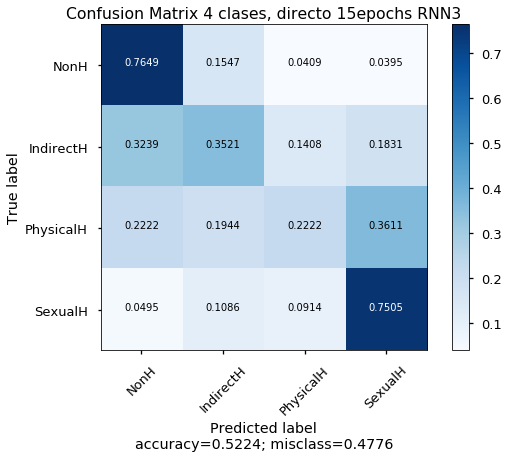

In [30]:
model3 = create_complex_GRU_3(256,128,64,"adam",X_train_rnn[0].shape) #modificar post experimentación
history3 = model3.fit(X_train_rnn, y_train,epochs=15,batch_size=64,verbose=0, validation_data=(X_val_rnn_ig, y_val))   
model3.save('baselines_4/rnn3_100_focal15.h5')

plt.plot(history3.history['loss'],label="Loss")
plt.plot(history3.history['val_loss'],label="Val Loss")
plt.title("Model Loss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(history3.history['acc'],label="Accuracy" )
plt.plot(history3.history['val_acc'],label="Val Accuracy" )
plt.title("Model Acc") 
plt.ylabel('acc')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predict = model3.predict(X_val_rnn_ig, batch_size=64).argmax(axis=-1)
acc_val= accuracy_score(y_val_num, predict)
f1_val=f1_score(y_val_num, predict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_num, predict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_num, predict, average=None) 
pre=precision_score(y_val_num, predict, average=None) 
matriz_val=confusion_matrix(y_val_num, predict)
print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH",'IndirectH','PhysicalH','SexualH'],"Confusion Matrix 4 clases, directo 15epochs RNN3")

### Convolucionales con gamma 3

Train on 6374 samples, validate on 2125 samples
Epoch 1/10
6374/6374 [==============================] - 9s 1ms/step - loss: 1.3393 - acc: 0.2757 - val_loss: 1.3014 - val_acc: 0.6202
Epoch 2/10
6374/6374 [==============================] - 4s 629us/step - loss: 0.9381 - acc: 0.3124 - val_loss: 0.9857 - val_acc: 0.6555
Epoch 3/10
6374/6374 [==============================] - 4s 596us/step - loss: 0.7466 - acc: 0.3655 - val_loss: 1.1391 - val_acc: 0.7864
Epoch 4/10
6374/6374 [==============================] - 4s 562us/step - loss: 0.7034 - acc: 0.4060 - val_loss: 0.8288 - val_acc: 0.6824
Epoch 5/10
6374/6374 [==============================] - 3s 547us/step - loss: 0.5839 - acc: 0.4380 - val_loss: 0.8336 - val_acc: 0.7073
Epoch 6/10
6374/6374 [==============================] - 4s 583us/step - loss: 0.5612 - acc: 0.4757 - val_loss: 0.7148 - val_acc: 0.4974
Epoch 7/10
6374/6374 [==============================] - 4s 568us/step - loss: 0.5100 - acc: 0.4749 - val_loss: 0.7387 - val_acc: 0.5534
Ep

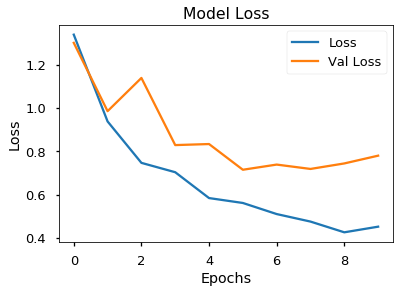

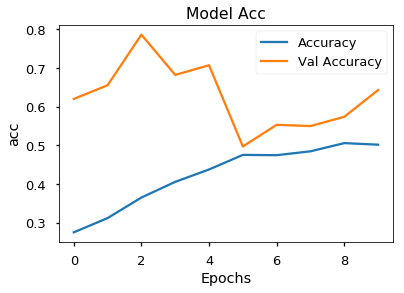

[0 0 2 0 2]
Accuracy sobre validacion: 0.643294117647
F1-score None sobre validación: [ 0.87341338  0.13031161  0.06549118  0.1982906 ]
F1-score macro sobre validación: 0.316876693994
Precision None sobre validación: [ 0.895218    0.08156028  0.03601108  0.96666667]
Recall None sobre validación: [ 0.85264568  0.32394366  0.36111111  0.11047619]


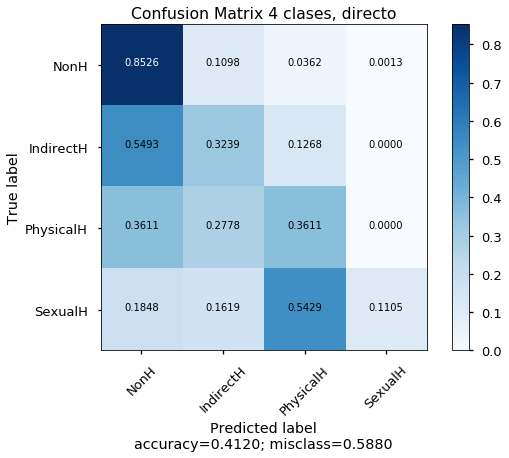

In [31]:
embedding_vector=100
embedding_layer = Embedding(input_dim=len(word_index.keys())+1,output_dim=embedding_vector,weights=[embedding_matrix],
                     input_length=max_input_lenght,trainable=False)

sequence_input = Input(shape=(max_input_lenght,))
embedded_sequences = embedding_layer(sequence_input)
batch = BatchNormalization()(embedded_sequences)
cov1= Conv1D(128, 5, activation='relu',padding='same')(batch)
pool = MaxPooling1D(pool_size=3)(cov1)    
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
cov1= Conv1D(64, 5, activation='relu',padding='same')(drop)
pool = MaxPooling1D(pool_size=3)(cov1)
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
flat = Flatten()(drop)
preds = Dense(64, activation='relu')(flat)
preds = BatchNormalization()(preds)
preds = Dense(4, activation='softmax')(preds)
model = Model(sequence_input, preds)
model.compile(loss=focal_loss(3, class_weights),optimizer='adam',metrics=['acc'])

history = model.fit(X_train, y_train,batch_size=64,epochs=10,verbose=1,validation_data=(X_val_ig,y_val),class_weight=class_weights)
model.save('baselines_4/cnn1_focal10_100_g3_64.h5')

plt.plot(history.history['loss'],label="Loss")
plt.plot(history.history['val_loss'],label="Val Loss")
plt.title("Model Loss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(history.history['acc'],label="Accuracy" )
plt.plot(history.history['val_acc'],label="Val Accuracy" )
plt.title("Model Acc") 
plt.ylabel('acc')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predict = model.predict(X_val_ig, batch_size=64)
predict= predict.argmax(axis=-1)
print (predict[:5])
acc_val= accuracy_score(y_val_num, predict)
f1_val=f1_score(y_val_num, predict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_num, predict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_num, predict, average=None) 
pre=precision_score(y_val_num, predict, average=None) 
matriz_val=confusion_matrix(y_val_num, predict)
print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH",'IndirectH','PhysicalH','SexualH'],"Confusion Matrix 4 clases, directo")

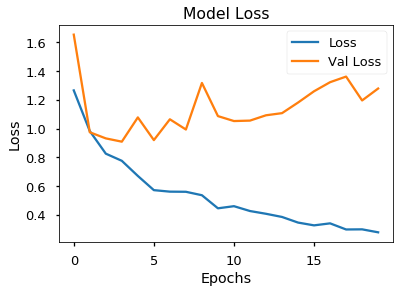

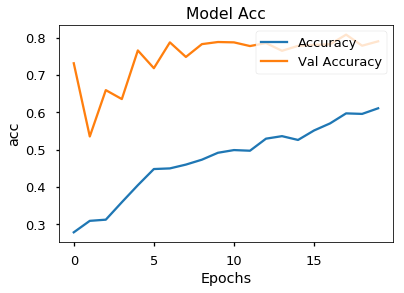

[0 0 3 0 0]
Accuracy sobre validacion: 0.790117647059
F1-score None sobre validación: [ 0.90675039  0.08163265  0.09137056  0.57662338]
F1-score macro sobre validación: 0.414094245131
Precision None sobre validación: [ 0.8534279   0.14814815  0.05590062  0.90612245]
Recall None sobre validación: [ 0.96718017  0.05633803  0.25        0.42285714]


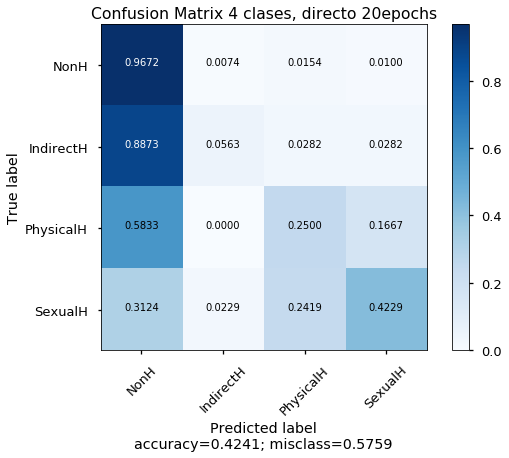

In [32]:
embedding_vector=100
embedding_layer = Embedding(input_dim=len(word_index.keys())+1,output_dim=embedding_vector,weights=[embedding_matrix],
                     input_length=max_input_lenght,trainable=False)

sequence_input = Input(shape=(max_input_lenght,))
embedded_sequences = embedding_layer(sequence_input)
batch = BatchNormalization()(embedded_sequences)
cov1= Conv1D(128, 5, activation='relu',padding='same')(batch)
pool = MaxPooling1D(pool_size=3)(cov1)    
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
cov1= Conv1D(64, 5, activation='relu',padding='same')(drop)
pool = MaxPooling1D(pool_size=3)(cov1)
batch = BatchNormalization()(pool)
drop = Dropout(0.65)(batch)
flat = Flatten()(drop)
preds = Dense(100, activation='relu')(flat)
preds = BatchNormalization()(preds)
preds = Dense(4, activation='softmax')(preds)
model = Model(sequence_input, preds)
model.compile(loss=focal_loss(3,weights=class_weights),optimizer='adam',metrics=['acc'])

history = model.fit(X_train, y_train,batch_size=64,epochs=20,verbose=0,validation_data=(X_val_ig,y_val),class_weight=class_weights)
model.save('baselines_4/cnn1_focal10_100_g3_100.h5')

plt.plot(history.history['loss'],label="Loss")
plt.plot(history.history['val_loss'],label="Val Loss")
plt.title("Model Loss") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(history.history['acc'],label="Accuracy" )
plt.plot(history.history['val_acc'],label="Val Accuracy" )
plt.title("Model Acc") 
plt.ylabel('acc')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predict = model.predict(X_val_ig, batch_size=64)
predict= predict.argmax(axis=-1)
print (predict[:5])
acc_val= accuracy_score(y_val_num, predict)
f1_val=f1_score(y_val_num, predict, average=None)  # labels=np.unique(trainPredict)
f1_val_ma=f1_score(y_val_num, predict, average='macro')  # labels=np.unique(trainPredict)
rec=recall_score(y_val_num, predict, average=None) 
pre=precision_score(y_val_num, predict, average=None) 
matriz_val=confusion_matrix(y_val_num, predict)
print ("Accuracy sobre validacion:",acc_val)  
print ("F1-score None sobre validación:",f1_val)
print ("F1-score macro sobre validación:",f1_val_ma)
print ("Precision None sobre validación:",pre)
print ("Recall None sobre validación:",rec)

plot_confusion_matrix(normalize(matriz_val,axis=1,norm='l1'),["NonH",'IndirectH','PhysicalH','SexualH'],"Confusion Matrix 4 clases, directo 20epochs")

In [33]:
np.save('matrices/X_train_4.npy', X_train)
np.save('matrices/y_train_4.npy', y_train)
np.save('matrices/X_val_ig_4.npy', X_val_ig)
np.save('matrices/y_val_4.npy', y_val)
np.save('matrices/y_train_num_4.npy',y_train_num)
np.save('matrices/y_val_num_4.npy',y_val_num)
np.save('matrices/X_train_rnn_4.npy',X_train_rnn)
np.save('matrices/X_val_rnn_ig_4.npy',X_val_rnn_ig)